In [3]:
from langgraph.graph import START, END, MessagesState
from langchain_community.tools import ShellTool
from langchain_ollama.chat_models import ChatOllama

In [25]:
import os 

def shell(command: str): 
    """
    shell is a tool to execute commands directly on the 
    linux shell 
    Args: 
        the first argument is named command : string 
    Returns: 
        the result of executing the command 
    """
    return os.popen(command).read()

llm = ChatOllama(model="llama3.1",tempreture=0).bind_tools([shell])
llm.invoke("I Watn you to make a directory named John ").tool_calls

[{'name': 'shell',
  'args': {'command': 'mkdir John'},
  'id': 'b38c1325-41d5-4dd1-9c6b-19f435cee709',
  'type': 'tool_call'}]

In [26]:
from langgraph.graph import START, END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

In [27]:
from langchain_core.messages import SystemMessage

sys_msg = SystemMessage(content="your a Linux AI assistant that has direct access to the shell to execute commands")


def planner(state: MessagesState): 
    print("--inside planner node")
    return {"messages": [llm.invoke([sys_msg] + state["messages"])]}

In [33]:
from langchain_core.messages import SystemMessage
def human(state: MessagesState): 
    print("--inside human node")
    tool_call = state["messages"][-1].tool_calls
    print(tool_call)
    command = tool_call[0]['args']
    print(command)
    choice = input("do you want to to execute: ")
    if choice == "yes": 
        return "tools"
    return "rethink"

def rethink(state: MessagesState): 
    rethink = SystemMessage(content="the tool or the arguments you choose for the tool is wrong please redo it")
    return {"messages": state["messages"] + rethink}

In [29]:
from langchain_core.messages import HumanMessage
msg = HumanMessage(content="can you create a directory named Ronny")
human(planner({"messages": [msg]}))

--inside planner node
--inside human node
[{'name': 'shell', 'args': {'command': 'mkdir Ronny'}, 'id': 'c7f6e135-c254-46e9-b005-b1a26fe18eec', 'type': 'tool_call'}]
{'command': 'mkdir Ronny'}


'planner'

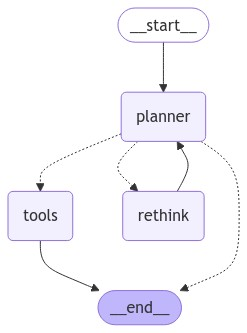

In [34]:
from IPython.display import display, Image
builder = StateGraph(MessagesState)
builder.add_node("planner",planner)
builder.add_node("tools",ToolNode([shell]))
builder.add_node("rethink",rethink)

builder.add_edge(START,"planner")
builder.add_edge("tools",END)
builder.add_edge("rethink", "planner")
builder.add_conditional_edges("planner",human)

workflow = builder.compile()
display(Image(workflow.get_graph().draw_mermaid_png()))

In [36]:
msg = HumanMessage(content="print the curent directory am in the argument for the tool is called command")
workflow.invoke({"messages": [msg]})

--inside planner node
--inside human node
[{'name': 'shell', 'args': {'command': 'pwd'}, 'id': '5fe11bf3-4ebf-43e9-b463-70271fed1acd', 'type': 'tool_call'}]
{'command': 'pwd'}


TypeError: can only concatenate list (not "SystemMessage") to list